## Defino el ambiente. 

Imprimo la ubicacion de la variable de entorno JAVA_HOME

Debe ser JAVA 64bits y la ruta no debe tener espacios ( Windows )

In [1]:
echo %JAVA_HOME%

C:\Progra~1\Java\jre1.8.0_271


Se configura pyspark para utilizar 20GB de RAM

In [2]:
import os
import pyspark

memory = '20g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

sc = pyspark.SparkContext('local[*]')

In [3]:
from pyspark.sql.types import StructType, DateType, IntegerType, StringType, DoubleType, BooleanType
from pyspark.sql.functions import datediff
import pandas as pd

In [4]:
sqlContext = pyspark.SQLContext(sc)

Defino el esquema de la tabla principal de los datos que se obtienen a partir de los CSVs.

Date – The date of the file in yyyy-mm-dd format.  
Serial Number – The manufacturer-assigned serial number of the drive.  
Model – The manufacturer-assigned model number of the drive.  
Capacity – The drive capacity in bytes.  
Failure – Contains a “0” if the drive is OK. Contains a “1” if this is the last day the drive was operational before failing.

In [5]:
schema = StructType() \
      .add("Date", DateType(),True) \
      .add("Serial_Number",StringType(),True) \
      .add("Model",StringType(),True) \
      .add("capacity_bytes",DoubleType(),True) \
      .add("Failure",IntegerType(),True)

Hago la lectura completa de los datos.

In [6]:
df_fullSet = sqlContext.read.options(header='True', delimiter=',') \
        .schema(schema) \
        .csv("../bigdata/**")

In [7]:
df_fullSet.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Serial_Number: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- capacity_bytes: double (nullable = true)
 |-- Failure: integer (nullable = true)



In [8]:
df_fullSet.write.mode('ignore').parquet("./output/fullSet.parquet")

In [9]:
df_fullSet_pq = sqlContext.read.load("./output/fullSet.parquet")

In [10]:
df_fullSet_pq.registerTempTable("tbl_AllDiskData")

In [11]:
df_fullSet_pq.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Serial_Number: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- capacity_bytes: double (nullable = true)
 |-- Failure: integer (nullable = true)



Creo un dataframe con el total de discos Discos del Datacenter con su fecha de puesta en funcionamiento y dia de retiro.

In [12]:
df_AllDisksDayInDayOut = sqlContext.sql('Select Serial_Number, Model, Min(Date) as DayIn, Max(Date) as DayOut, CAST(FIRST(capacity_bytes/1099511627776) AS DECIMAL(10,2)) as SizeInTB, Count(1) as DayCount from tbl_AllDiskData group by Serial_Number, Model order by Model')

Guardo el resultado anterior como archivo de parquet comprimido para utilizar como de  futuras consultas y asi
obtener mayor velocidad para la realizacion de futuras consultas.

In [13]:
df_AllDisksDayInDayOut.write.mode('ignore').parquet("./output/tbl_allDisksDayInDayOut.parquet")

Leo el resultado del parquet y lo cargo a un nuevo dataframe.

In [14]:
df_allDisksDayInDayOut_pq = sqlContext.read.load("./output/tbl_allDisksDayInDayOut.parquet")

Esquema de tabla df_allDisksDayInDayOut_pq

In [15]:
df_allDisksDayInDayOut_pq.printSchema()

root
 |-- Serial_Number: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- DayIn: date (nullable = true)
 |-- DayOut: date (nullable = true)
 |-- SizeInTB: decimal(10,2) (nullable = true)
 |-- DayCount: long (nullable = true)



Registro la tabla como tbl_AllDisksDayInDayOut.

In [16]:
df_allDisksDayInDayOut_pq.registerTempTable("tbl_AllDisksDayInDayOut")

Lista de tablas disponibles

In [296]:
schemaMakers = StructType() \
      .add("Model",StringType(),True) \
      .add("Maker",StringType(),True)

In [297]:
df_makers = sqlContext.read.options(header='True', delimiter=',') \
        .schema(schemaMakers) \
        .csv("./makers.csv")

In [298]:
df_makers.registerTempTable("tbl_makers")

In [299]:
sqlContext.sql('show tables').show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
|        |     tbl_alldiskdata|       true|
|        |tbl_alldisksdayin...|       true|
|        |          tbl_makers|       true|
+--------+--------------------+-----------+



##  Comienzo con las consultas.

#### Total de discos que existieron en el datacenter agrupados por modelo.

In [18]:
sqlContext.sql('Select Model, Count(1) as Count from tbl_AllDisksDayInDayOut group by Model order by Count desc').show()

+--------------------+-----+
|               Model|Count|
+--------------------+-----+
|       ST12000NM0007|38730|
|         ST4000DM000|37035|
|       ST12000NM0008|18470|
| TOSHIBA MG07ACA14TA|17476|
|HGST HMS5C4040BLE640|16346|
|        ST8000NM0055|15006|
|HGST HUH721212ALN604|10917|
|         ST8000DM002|10221|
|HGST HMS5C4040ALE640| 8723|
|       ST12000NM001G| 6158|
|Hitachi HDS722020...| 4774|
|         ST3000DM001| 4707|
|Hitachi HDS5C3030...| 4664|
|Hitachi HDS5C4040...| 2719|
|HGST HUH721212ALE600| 2611|
|       ST14000NM001G| 2400|
|        ST31500541AS| 2188|
|         ST6000DX000| 1939|
|HGST HUH721212ALE604| 1911|
|        WDC WD30EFRX| 1335|
+--------------------+-----+
only showing top 20 rows



#### Total de discos que existieron en el datacenter agrupados por fabricante.

In [359]:
disksPerMaker = sqlContext.sql('Select Makers.Maker, Sum(Disks.Count) as Total from (Select Maker, Model from tbl_makers) as Makers inner join (Select Model, Count(1) as Count from tbl_AllDisksDayInDayOut group by Model order by Count desc) as Disks on Disks.Model = Makers.Model group by Makers.Maker order by Maker desc')

In [360]:
disksPerMaker.show()

+---------------+------+
|          Maker| Total|
+---------------+------+
|Western Digital|  4025|
|        Toshiba| 18844|
|        Seagate|143144|
|        Samsung|    18|
|          Other|   100|
|        Hitachi| 55094|
+---------------+------+



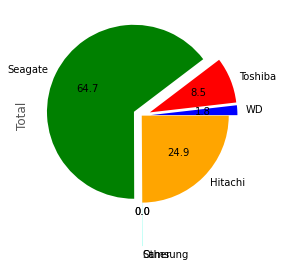

In [369]:
disksPerMaker_pd = disksPerMaker.toPandas()
disksPerMaker_pd.plot.pie(labels=['WD', 'Toshiba', 'Seagate', 'Samsung', 'Other', 'Hitachi'], explode=[0.1, 0.1, 0.1, 0.5, 0.5, 0],  y='Total', autopct='%.1f', legend=False, colors=['blue', 'red', 'green', 'yellow', 'cyan', 'orange'])

#### Cantidad promedio de días que un dura un disco duro en operacion según su modelo, ordenados por cantidad de dias en operacion.

In [19]:
sqlContext.sql('Select CAST(AVG(DATEDIFF(DayOut, DayIn)) AS DECIMAL(10,0)) as Days, Model from tbl_AllDisksDayInDayOut Group by Model order by Days desc').show()

+----+--------------------+
|Days|               Model|
+----+--------------------+
|1888|      WDC WD5000BPKT|
|1753| TOSHIBA MD04ABA400V|
|1715|      WDC WD5000LPVX|
|1703|Hitachi HDS5C4040...|
|1637|         ST6000DX000|
|1591|      ST1000LM024 HN|
|1575|         ST4000DM000|
|1571|      WDC WD2500AAJS|
|1542|        WDC WD40EFRX|
|1530|       ST500LM012 HN|
|1507|HGST HMS5C4040ALE640|
|1491|         ST9320325AS|
|1487|Hitachi HDS5C3030...|
|1477|      WDC WD3200AAKS|
|1477|Hitachi HDS5C3030...|
|1446|      WDC WD5000LPCX|
|1433|HGST HMS5C4040BLE640|
|1428| TOSHIBA MD04ABA500V|
|1427|Hitachi HDS723030...|
|1423|Hitachi HDS723030...|
+----+--------------------+
only showing top 20 rows



#### Cantidad de discos nuevos que ingresaron por año y tamaño aproximado por disco.

In [229]:
disksPerYearIn = sqlContext.sql('Select Year(DayIn) as Year, COUNT(Serial_Number) as DriveCount, Sum(SizeInTB) as SizeInTB, Cast(Sum(SizeInTB)/COUNT(Serial_Number) as Decimal(10,2)) as `AVG size per disk` from tbl_AllDisksDayInDayOut Group by Year order by Year asc')

In [230]:
disksPerYearIn.show()

+----+----------+---------+-----------------+
|Year|DriveCount| SizeInTB|AVG size per disk|
+----+----------+---------+-----------------+
|2013|     29072| 76776.20|             2.64|
|2014|     20035|166648.06|             8.32|
|2015|     20211| 75692.28|             3.75|
|2016|     23030|114172.93|             4.96|
|2017|     33516|237143.00|             7.08|
|2018|     29849|317317.81|            10.63|
|2019|     27790|299931.30|            10.79|
|2020|     37723|433749.23|            11.50|
+----+----------+---------+-----------------+



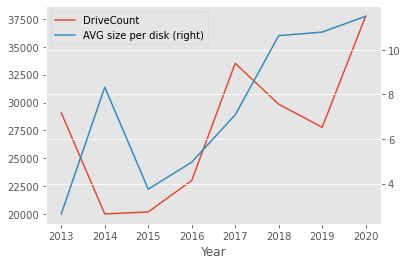

In [245]:
disksPerYearIn_pd = disksPerYearIn.toPandas()
disksPerYearIn_pd = disksPerYearIn_pd[['Year','DriveCount','AVG size per disk']]
disksPerYearIn_pd = disksPerYearIn_pd.astype(float)
disksPerYearIn_pd.plot(x='Year', secondary_y=['AVG size per disk'])

#### Cantidad de discos que se dieron de baja por año.

In [23]:
disksPerYearOut = sqlContext.sql('Select Year(DayOut) as Year, COUNT(Serial_Number) as Count from tbl_AllDisksDayInDayOut where Year(DayOut) < 2020  Group by Year order by Year asc')

In [24]:
disksPerYearOut.show()

+----+-----+
|Year|Count|
+----+-----+
|2013| 1273|
|2014| 5131|
|2015| 4769|
|2016| 6397|
|2017|13331|
|2018|15965|
|2019|11363|
+----+-----+



#### Cantidad de PB en el Datacenter por modelo de disco duro

In [25]:
sqlContext.sql('select Model, CAST(SUM(SizeInTB/1024) AS DECIMAL(10,2)) as PB, Count(1) as DriveCount from tbl_AllDisksDayInDayOut group by model order by PB desc').show()

+--------------------+------+----------+
|               Model|    PB|DriveCount|
+--------------------+------+----------+
|       ST12000NM0007|412.63|     38730|
| TOSHIBA MG07ACA14TA|217.25|     17476|
|       ST12000NM0008|196.78|     18470|
|         ST4000DM000|131.55|     37035|
|HGST HMS5C4040ALE640|126.33|      8723|
|HGST HUH721212ALN604|116.31|     10917|
|        ST8000NM0055|106.68|     15006|
|         ST8000DM002| 72.67|     10221|
|       ST12000NM001G| 65.61|      6158|
|HGST HMS5C4040BLE640| 58.11|     16346|
|       ST14000NM001G| 29.84|      2400|
|HGST HUH721212ALE600| 27.82|      2611|
|HGST HUH721212ALE604| 20.36|      1911|
|         ST3000DM001| 12.55|      4707|
|Hitachi HDS5C3030...| 12.43|      4664|
|       ST10000NM0086| 11.09|      1248|
|         ST6000DX000| 10.34|      1939|
|Hitachi HDS5C4040...|  9.67|      2719|
|Hitachi HDS722020...|  8.48|      4774|
|HGST HUH728080ALE600|  7.95|      1118|
+--------------------+------+----------+
only showing top

#### Cantidad de PB agregados al Datacenter por año

In [246]:
df_TBperYear = sqlContext.sql('Select Year(DayIn) as Year, CAST(SUM(SizeInTB/1024) AS DECIMAL(10,2)) as PB, Count(1) as DriveCount from tbl_AllDisksDayInDayOut group by Year(DayIn) order by Year asc')

In [247]:
df_TBperYear.show()

+----+------+----------+
|Year|    PB|DriveCount|
+----+------+----------+
|2013| 74.98|     29072|
|2014|162.74|     20035|
|2015| 73.92|     20211|
|2016|111.50|     23030|
|2017|231.59|     33517|
|2018|309.88|     29849|
|2019|292.90|     27790|
|2020|423.58|     37723|
+----+------+----------+



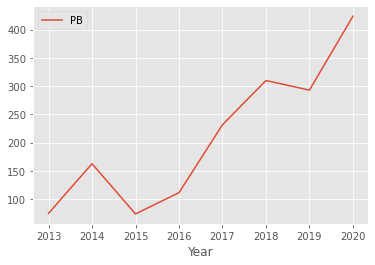

In [250]:
df_TBperYear_pd = df_TBperYear.toPandas()
df_TBperYear_pd=df_TBperYear_pd.astype(float)
df_TBperYear_pd.plot(x='Year', y='PB')

#### Cantidad de discos que fallaron vs discos en el data center discriminado por año

In [286]:
failuresVSDisks = sqlContext.sql('Select Failures.Year, Count as DiskCount, Failures, CAST(((Failures/Count)*100) AS DECIMAL(10,2)) as Ratio from (select count(distinct Serial_Number) as Count, Year(Date) as Year from tbl_alldiskdata group by Year(date)) as Disks inner Join (select Count(Failure) as Failures, Year(Date) as Year from tbl_alldiskdata where Failure = 1 group by year(Date) order by Year) as Failures on Disks.Year = Failures.Year order by Failures.Year')

In [287]:
failuresVSDisks.show()

+----+---------+--------+-----+
|Year|DiskCount|Failures|Ratio|
+----+---------+--------+-----+
|2013|    29072|     740| 2.55|
|2014|    47793|    2206| 4.62|
|2015|    62898|    1429| 2.27|
|2016|    81173|    1431| 1.76|
|2017|   108282|    1556| 1.44|
|2018|   124326|    1381| 1.11|
|2019|   136568|    2263| 1.66|
|2020|   162997|    1093| 0.67|
+----+---------+--------+-----+



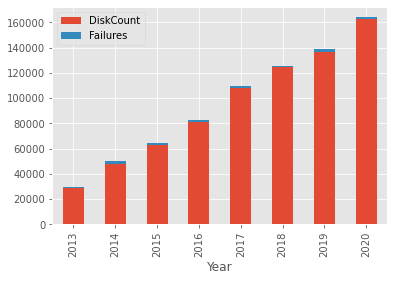

In [288]:
failuresVSDisks_pd = failuresVSDisks.toPandas()
failuresVSDisks_pd = failuresVSDisks_pd[['Year','DiskCount','Failures']]
failuresVSDisks_pd.plot.bar(x='Year', stacked=True)

### Proyecciones

In [174]:
from sklearn import linear_model
from sklearn.metrics import r2_score

#### Cantidad de discos estimadas para el año 2021 y 2022

In [200]:
y_train = failuresVSDisks_pd['DiskCount'].values
x_train = np.array(failuresVSDisks_pd['Year'].values).reshape((-1, 1))
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_train)

In [202]:
anio = regr.predict([[2021]])
print('Discos estimados para 2021:', int(anio)) 

Discos estimados para 2021: 179464


In [370]:
anio = regr.predict([[2022]])
print('Discos estimados para 2022:', int(anio)) 

Discos estimados para 2022: 198425


In [204]:
# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % r2_score(y_train, y_pred))

Coefficients: 
 [18961.22619048]
Independent term: 
 -38141173.98809524
Variance score: 0.99


#### Fallas de discos calculadas para 2021

In [371]:
y_train = failuresVSDisks_pd['Failures'].values
x_train = np.array(failuresVSDisks_pd['Year'].values).reshape((-1, 1))
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_train)
anio = regr.predict([[2021]])
print('Discos a reemplazarse en 2021:', int(anio)) 

Discos a reemplazarse en 2021: 1659
